### Data Preprocessing

In [1]:
import ijson
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

json_file_path = 'dblp.v12.json'
papers = []

def get_field(element, field, default=np.nan, transform=None):
    """Extracts a field from a JSON element with optional transformation."""
    value = element.get(field, default)
    return transform(value) if transform and value is not default else value

with open(json_file_path, "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        try:
            paper = {
                'id': element['id'],
                'title': element['title'],
                'authors': get_field(element, 'authors'),
                'year': get_field(element, 'year'),
                'n_citation': get_field(element, 'n_citation', default=0),
                'reference_count': len(element['references']) if 'references' in element else np.nan,
                'references': ';'.join(str(int(r)) for r in element['references']) if 'references' in element else np.nan,
                'publisher': get_field(element, 'publisher'),
                'doc_type': get_field(element, 'doc_type'),
                'doi': get_field(element, 'doi', transform=lambda doi: f"https://doi.org/{doi}")
            }
            articles.append(paper)
        except Exception as e:
            print(f"Error processing record {i}: {e}")



4894081it [16:38, 4903.10it/s] 


In [2]:
len(papers)


4894081

In [4]:
import pandas as pd
df = pd.DataFrame(papers)
df

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013,1,2.0,2005687710;2018037215,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000,1,NaN,NaN,,Journal,https://doi.org/
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011,1,15.0,1535888970;1992876689;1993710814;2035653341;20...,Eurographics Association,Conference,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",2009,6,3.0,1560724230;1986968751;2156909104,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009,0,NaN,NaN,,Conference,https://doi.org/
...,...,...,...,...,...,...,...,...,...,...
4894076,99905544,A Naïve-Bayesian methodology to classify echo ...,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2010,2,8.0,1562217771;1625504505;2015022770;2108751703;21...,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-24788-0_15
4894077,99884553,Blind Equalization for underwater communications,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",2014,0,NaN,NaN,University of Twente,,https://doi.org/10.3990/1.9789036536806
4894078,999847014,Technical Implementation and Feasibility,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",2015,1,6.0,1940933138;1975620021;1978183200;2097595927;21...,Springer International Publishing,,https://doi.org/10.1007/978-3-319-14439-9_9
4894079,9990887,Knowledge Patterns in Databases,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",2011,0,NaN,NaN,IGI Global,,https://doi.org/10.4018/978-1-59904-931-1.ch081


In [8]:
#to numeric citation_count
df['citation_count'] = pd.to_numeric(df['n_citation'], errors='coerce')

sorted_df = df.sort_values(by='citation_count', ascending=False)

# Select the top 10,000 papers
top_papers = sorted_df.head(10000)

# Save or print the results
# You can either print the top papers or save them to a new CSV file
print(top_papers)
# or
top_papers.to_csv('top_10000_papers.csv', index=False)

                 id                                              title  \
4696136  2041404167           The Mathematical Theory of Communication   
4630907  1639032689  Genetic algorithms in search, optimization, an...   
4092588  2912565176                                         Fuzzy sets   
2937610  2151103935  Distinctive Image Features from Scale-Invarian...   
4088311  2911964244                                     Random Forests   
...             ...                                                ...   
794854   1964830323          An overview of JML tools and applications   
1705406  2060553764  Trust and e-commerce: a study of consumer perc...   
1782398  2068691410               Geographic routing in city scenarios   
2621703  2147343704  EVENODD: an efficient scheme for tolerating do...   
2109151  2101699859  Countering code-injection attacks with instruc...   

                                                   authors  year  n_citation  \
4696136  [{'name': 'C. E. Shann

#### Citation Graph

In [16]:
import networkx as nx
import ast
# Creating the Citation Graph
df = pd.read_csv('top_10000_papers.csv')

# Creating the Citation Graph
citation_graph = nx.DiGraph()

# Add nodes (papers)
citation_graph.add_nodes_from(df['id'])

# Add edges (citations)
for index, row in df.iterrows():
    paper_id = row['id']
    if pd.notna(row['references']):
        references = row['references'].split(';')
        for ref in references:
            ref_id = int(ref)
            if ref_id in citation_graph:
                citation_graph.add_edge(paper_id, ref_id)
print(f"# of nodes in the citation graph : {len(citation_graph.nodes())}")
print(f"# of edges in the citation graph : {len(citation_graph.edges())}")

# of nodes in the citation graph : 10000
# of edges in the citation graph : 52252


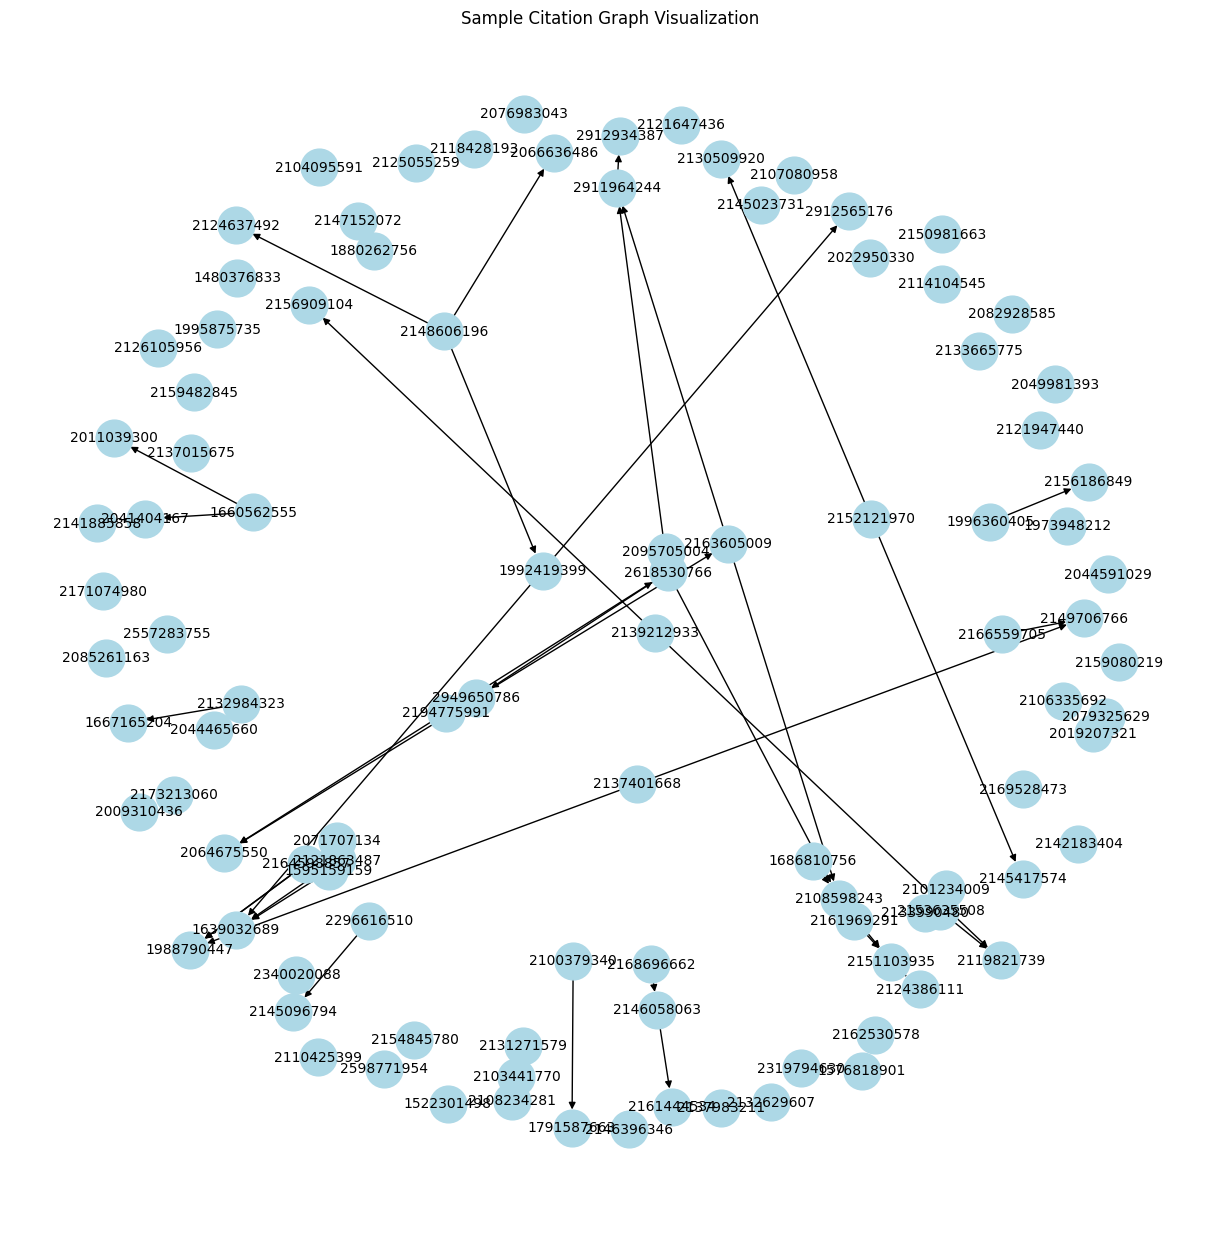

In [24]:

# Sample a small subset of the citation graph for visualization
sub_citation_graph = citation_graph.subgraph(list(citation_graph.nodes)[:100])

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(sub_citation_graph, with_labels=True, node_size=700, node_color='lightblue', 
        arrows=True, font_size=10)
plt.title("Sample Citation Graph Visualization")
plt.show()


#### Collaboration Graphs

In [22]:
import pandas as pd
import networkx as nx
import ast


# Creating the Collaboration Graph
collaboration_graph = nx.Graph()

# Function to add or update edges between authors of a paper
def add_or_update_collaboration_edges(row):
    if pd.notna(row['authors']):
        authors = ast.literal_eval(row['authors'])
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]['name']
                author2 = authors[j]['name']
                if collaboration_graph.has_edge(author1, author2):
                    collaboration_graph[author1][author2]['weight'] += 1
                else:
                    collaboration_graph.add_edge(author1, author2, weight=1)

# Apply the function to each row in the DataFrame
df.apply(add_or_update_collaboration_edges, axis=1)

# The collaboration_graph now contains the desired relationships and weights.
print(f"# of nodes in the collaboration graph : {len(collaboration_graph.nodes())}")
print(f"# of edges in the collaboration graph : {len(collaboration_graph.edges())}")


# of nodes in the collaboration graph : 21993
# of edges in the collaboration graph : 139157
